# 🧹 02. Data Cleaning - Очистка данных

**Цель:** Подготовить чистый датасет для моделирования

**План:**
1. ❓ Missing Values - обработка пропусков
2. 🎯 Outliers - выбросы
3. 🔄 Duplicates - дубликаты
4. ✅ Data Validation - валидация
5. 💾 Export - сохранение

---

## 🔧 Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import IsolationForest

pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print('✅ Библиотеки загружены!')

✅ Библиотеки загружены!


In [2]:
# Загрузка данных
df = pd.read_csv('../data/raw/krisha_100.csv')

print(f'📊 Исходные данные: {df.shape[0]:,} строк × {df.shape[1]} колонок')
print(f'💾 Память: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB')

# Сохраняем копию для сравнения
df_original = df.copy()
print('\n✅ Данные загружены, копия создана')

📊 Исходные данные: 15,410 строк × 8 колонок
💾 Память: 3.62 MB

✅ Данные загружены, копия создана


---
# 1️⃣ MISSING VALUES - Пропущенные значения

In [3]:
# Анализ пропусков
print('='*60)
print('❓ АНАЛИЗ ПРОПУЩЕННЫХ ЗНАЧЕНИЙ')
print('='*60)

missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100

missing_df = pd.DataFrame({
    'Колонка': missing.index,
    'Пропусков': missing.values,
    'Процент': missing_pct.values
})

missing_df = missing_df[missing_df['Пропусков'] > 0].sort_values('Пропусков', ascending=False)

if len(missing_df) > 0:
    print('\nКолонки с пропусками:')
    print(missing_df.to_string(index=False))
else:
    print('\n✅ Нет пропущенных значений!')

❓ АНАЛИЗ ПРОПУЩЕННЫХ ЗНАЧЕНИЙ

Колонки с пропусками:
      Колонка  Пропусков  Процент
microdistrict          1 0.006489


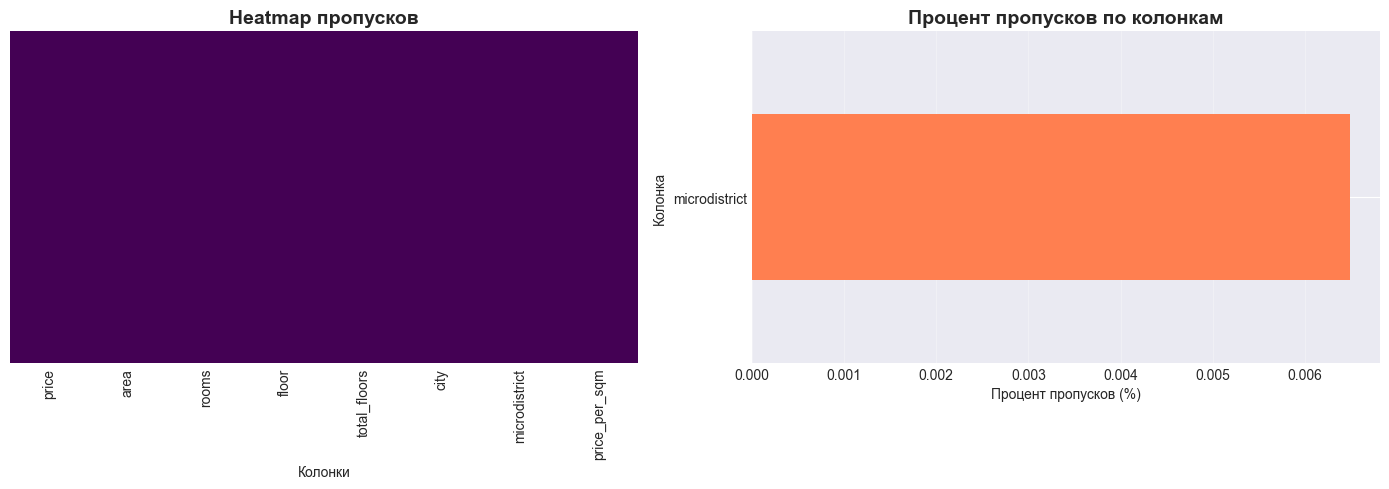


✅ График сохранён: reports/figures/eda/missing_values.png


In [4]:
# Визуализация пропусков (если есть)
if missing_df.shape[0] > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # 1. Heatmap
    sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis', ax=axes[0])
    axes[0].set_title('Heatmap пропусков', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Колонки')
    
    # 2. Bar chart
    missing_df.plot(kind='barh', x='Колонка', y='Процент', ax=axes[1], legend=False, color='coral')
    axes[1].set_xlabel('Процент пропусков (%)')
    axes[1].set_title('Процент пропусков по колонкам', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.savefig('../reports/figures/eda/missing_values.png', dpi=300, bbox_inches='tight')
    plt.show()
    print('\n✅ График сохранён: reports/figures/eda/missing_values.png')
else:
    print('Пропусков нет - график не требуется')

In [5]:
# Стратегия обработки пропусков
print('\n📋 СТРАТЕГИЯ ОБРАБОТКИ ПРОПУСКОВ:\n')

# Для microdistrict (если есть пропуски)
if 'microdistrict' in df.columns and df['microdistrict'].isnull().sum() > 0:
    print('1. microdistrict:')
    print('   - Пропусков:', df['microdistrict'].isnull().sum())
    print('   - Решение: заполнить значением "Неизвестно"')
    df['microdistrict'].fillna('Неизвестно', inplace=True)
    print('   ✅ Выполнено')

# Для числовых колонок (если есть)
numeric_cols_with_missing = df.select_dtypes(include=[np.number]).columns[df.select_dtypes(include=[np.number]).isnull().any()]

if len(numeric_cols_with_missing) > 0:
    print('\n2. Числовые колонки с пропусками:')
    for col in numeric_cols_with_missing:
        print(f'   - {col}: удалить строки (критичная информация)')
        df = df[df[col].notna()]
    print('   ✅ Выполнено')

print(f'\n📊 После обработки пропусков: {df.shape[0]:,} строк')
print(f'   Удалено строк: {len(df_original) - len(df):,}')


📋 СТРАТЕГИЯ ОБРАБОТКИ ПРОПУСКОВ:

1. microdistrict:
   - Пропусков: 1
   - Решение: заполнить значением "Неизвестно"
   ✅ Выполнено

📊 После обработки пропусков: 15,410 строк
   Удалено строк: 0


---
# 2️⃣ OUTLIERS - Выбросы

In [6]:
print('='*60)
print('🎯 ДЕТЕКЦИЯ ВЫБРОСОВ')
print('='*60)

# Функция для IQR метода
def detect_outliers_iqr(data, column, multiplier=1.5):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - (multiplier * IQR)
    upper_bound = Q3 + (multiplier * IQR)
    
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    
    print(f'\n{column}:')
    print(f'  Q1: {Q1:,.2f}')
    print(f'  Q3: {Q3:,.2f}')
    print(f'  IQR: {IQR:,.2f}')
    print(f'  Нижняя граница: {lower_bound:,.2f}')
    print(f'  Верхняя граница: {upper_bound:,.2f}')
    print(f'  Выбросов: {len(outliers):,} ({len(outliers)/len(data)*100:.2f}%)')
    
    return outliers, lower_bound, upper_bound

# Проверяем основные числовые колонки
numeric_cols = ['price', 'area', 'rooms', 'floor', 'total_floors']
outliers_info = {}

for col in numeric_cols:
    if col in df.columns:
        outliers, lower, upper = detect_outliers_iqr(df, col, multiplier=2.0)
        outliers_info[col] = {'outliers': outliers, 'lower': lower, 'upper': upper}

🎯 ДЕТЕКЦИЯ ВЫБРОСОВ

price:
  Q1: 14,000,000.00
  Q3: 28,000,000.00
  IQR: 14,000,000.00
  Нижняя граница: -14,000,000.00
  Верхняя граница: 56,000,000.00
  Выбросов: 598 (3.88%)

area:
  Q1: 45.10
  Q3: 72.50
  IQR: 27.40
  Нижняя граница: -9.70
  Верхняя граница: 127.30
  Выбросов: 327 (2.12%)

rooms:
  Q1: 2.00
  Q3: 3.00
  IQR: 1.00
  Нижняя граница: 0.00
  Верхняя граница: 5.00
  Выбросов: 9 (0.06%)

floor:
  Q1: 2.00
  Q3: 5.00
  IQR: 3.00
  Нижняя граница: -4.00
  Верхняя граница: 11.00
  Выбросов: 119 (0.77%)

total_floors:
  Q1: 5.00
  Q3: 9.00
  IQR: 4.00
  Нижняя граница: -3.00
  Верхняя граница: 17.00
  Выбросов: 0 (0.00%)


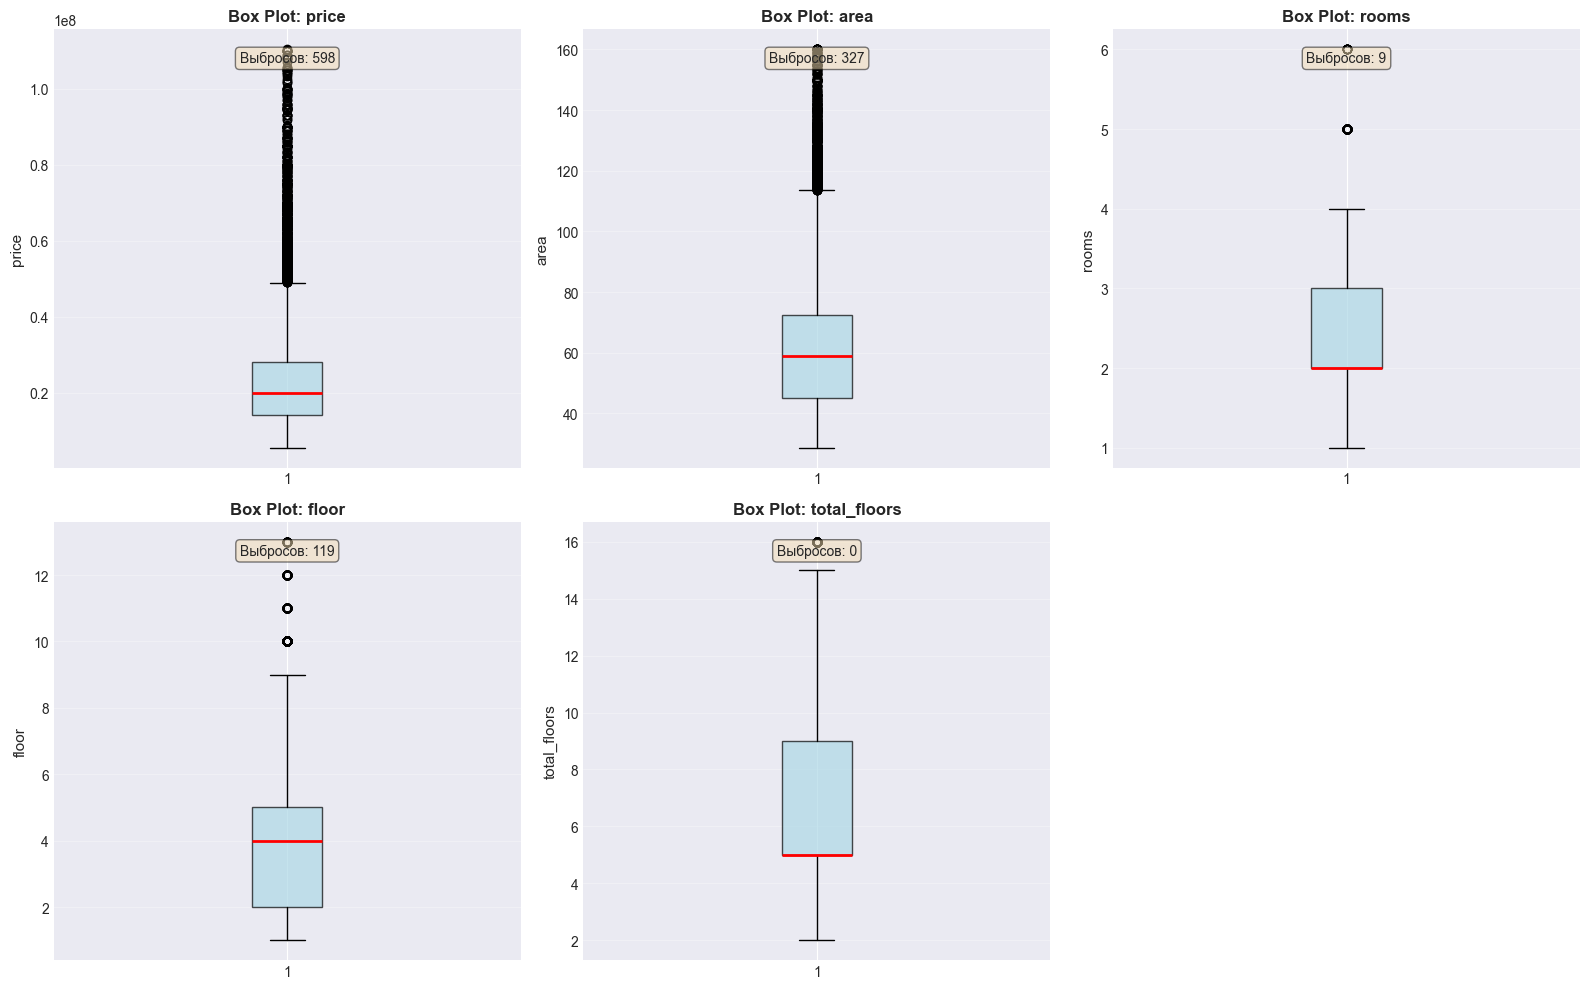


✅ График сохранён: reports/figures/eda/outliers_boxplots.png


In [7]:
# Визуализация выбросов - Box plots
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

for idx, col in enumerate(numeric_cols):
    if col in df.columns and idx < 6:
        axes[idx].boxplot(df[col], vert=True, patch_artist=True,
                         boxprops=dict(facecolor='lightblue', alpha=0.7),
                         medianprops=dict(color='red', linewidth=2))
        axes[idx].set_ylabel(col, fontsize=11)
        axes[idx].set_title(f'Box Plot: {col}', fontsize=12, fontweight='bold')
        axes[idx].grid(True, alpha=0.3, axis='y')
        
        # Добавляем статистику
        if col in outliers_info:
            n_outliers = len(outliers_info[col]['outliers'])
            axes[idx].text(0.5, 0.95, f'Выбросов: {n_outliers}', 
                          transform=axes[idx].transAxes, 
                          ha='center', va='top',
                          bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Скрываем пустые subplot'ы
for idx in range(len(numeric_cols), 6):
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('../reports/figures/eda/outliers_boxplots.png', dpi=300, bbox_inches='tight')
plt.show()
print('\n✅ График сохранён: reports/figures/eda/outliers_boxplots.png')

In [8]:
# Метод Z-score
print('\n📊 Z-SCORE METHOD (дополнительно):')

def detect_outliers_zscore(data, column, threshold=3):
    z_scores = np.abs((data[column] - data[column].mean()) / data[column].std())
    outliers = data[z_scores > threshold]
    
    print(f'\n{column}:')
    print(f'  Среднее: {data[column].mean():,.2f}')
    print(f'  Стд. откл.: {data[column].std():,.2f}')
    print(f'  Выбросов (|Z| > {threshold}): {len(outliers):,} ({len(outliers)/len(data)*100:.2f}%)')
    
    return outliers

for col in ['price', 'area']:
    if col in df.columns:
        _ = detect_outliers_zscore(df, col, threshold=3)


📊 Z-SCORE METHOD (дополнительно):

price:
  Среднее: 23,477,604.93
  Стд. откл.: 14,515,006.89
  Выбросов (|Z| > 3): 312 (2.02%)

area:
  Среднее: 62.43
  Стд. откл.: 23.21
  Выбросов (|Z| > 3): 251 (1.63%)


In [9]:
# Isolation Forest (ML подход)
print('\n🤖 ISOLATION FOREST METHOD:')

# Выбираем числовые признаки для анализа
features_for_if = ['price', 'area', 'rooms']
X = df[features_for_if].copy()

# Обучаем Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
predictions = iso_forest.fit_predict(X)

# -1 = выброс, 1 = нормальное значение
n_outliers_if = (predictions == -1).sum()

print(f'\nВыбросов найдено: {n_outliers_if:,} ({n_outliers_if/len(df)*100:.2f}%)')
print(f'Нормальных значений: {(predictions == 1).sum():,}')

df['is_outlier_if'] = predictions == -1


🤖 ISOLATION FOREST METHOD:

Выбросов найдено: 771 (5.00%)
Нормальных значений: 14,639


In [10]:
# РЕШЕНИЕ по выбросам
print('\n' + '='*60)
print('✂️ УДАЛЕНИЕ ВЫБРОСОВ')
print('='*60)

df_before_outliers = df.copy()

# Удаляем экстремальные выбросы по price (IQR с множителем 2.0)
if 'price' in outliers_info:
    lower = outliers_info['price']['lower']
    upper = outliers_info['price']['upper']
    
    df = df[(df['price'] >= lower) & (df['price'] <= upper)]
    print(f'\n✅ Price: удалено {len(df_before_outliers) - len(df):,} строк')

# Удаляем выбросы по area
if 'area' in outliers_info:
    lower = outliers_info['area']['lower']
    upper = outliers_info['area']['upper']
    
    df_before = len(df)
    df = df[(df['area'] >= lower) & (df['area'] <= upper)]
    print(f'✅ Area: удалено {df_before - len(df):,} строк')

print(f'\n📊 После удаления выбросов: {df.shape[0]:,} строк')
print(f'   Всего удалено: {len(df_before_outliers) - len(df):,} строк ({(len(df_before_outliers) - len(df))/len(df_before_outliers)*100:.2f}%)')


✂️ УДАЛЕНИЕ ВЫБРОСОВ

✅ Price: удалено 598 строк
✅ Area: удалено 156 строк

📊 После удаления выбросов: 14,656 строк
   Всего удалено: 754 строк (4.89%)


---
# 3️⃣ DUPLICATES - Дубликаты

In [11]:
print('='*60)
print('🔄 АНАЛИЗ ДУБЛИКАТОВ')
print('='*60)

# Полные дубликаты
n_duplicates = df.duplicated().sum()
print(f'\nПолных дубликатов: {n_duplicates:,} ({n_duplicates/len(df)*100:.2f}%)')

if n_duplicates > 0:
    print('\nПримеры дубликатов:')
    duplicates = df[df.duplicated(keep=False)]
    print(duplicates.head(10))
    
    # Удаляем дубликаты
    df = df.drop_duplicates()
    print(f'\n✅ Дубликаты удалены')
    print(f'   Осталось строк: {len(df):,}')
else:
    print('✅ Дубликатов не найдено!')

🔄 АНАЛИЗ ДУБЛИКАТОВ

Полных дубликатов: 0 (0.00%)
✅ Дубликатов не найдено!


---
# 4️⃣ DATA VALIDATION - Валидация

In [12]:
print('='*60)
print('✅ ВАЛИДАЦИЯ ДАННЫХ')
print('='*60)

# 1. Проверка диапазонов
print('\n1. Проверка диапазонов:')

# Price
MIN_PRICE = 5_000_000  # 5M тенге
MAX_PRICE = 150_000_000  # 150M тенге
invalid_price = df[(df['price'] < MIN_PRICE) | (df['price'] > MAX_PRICE)]
print(f'   Price вне диапазона [{MIN_PRICE:,} - {MAX_PRICE:,}]: {len(invalid_price):,}')

# Area
MIN_AREA = 15  # 15 м²
MAX_AREA = 200  # 200 м²
invalid_area = df[(df['area'] < MIN_AREA) | (df['area'] > MAX_AREA)]
print(f'   Area вне диапазона [{MIN_AREA} - {MAX_AREA}]: {len(invalid_area):,}')

# Rooms
MIN_ROOMS = 1
MAX_ROOMS = 6
invalid_rooms = df[(df['rooms'] < MIN_ROOMS) | (df['rooms'] > MAX_ROOMS)]
print(f'   Rooms вне диапазона [{MIN_ROOMS} - {MAX_ROOMS}]: {len(invalid_rooms):,}')

# Удаляем невалидные данные
df_before_validation = len(df)
df = df[
    (df['price'] >= MIN_PRICE) & (df['price'] <= MAX_PRICE) &
    (df['area'] >= MIN_AREA) & (df['area'] <= MAX_AREA) &
    (df['rooms'] >= MIN_ROOMS) & (df['rooms'] <= MAX_ROOMS)
]

print(f'\n   ✅ Удалено невалидных строк: {df_before_validation - len(df):,}')

✅ ВАЛИДАЦИЯ ДАННЫХ

1. Проверка диапазонов:
   Price вне диапазона [5,000,000 - 150,000,000]: 0
   Area вне диапазона [15 - 200]: 0
   Rooms вне диапазона [1 - 6]: 0

   ✅ Удалено невалидных строк: 0


In [13]:
# 2. Логические проверки
print('\n2. Логические проверки:')

# floor <= total_floors
invalid_floor = df[df['floor'] > df['total_floors']]
print(f'   floor > total_floors: {len(invalid_floor):,}')

if len(invalid_floor) > 0:
    df = df[df['floor'] <= df['total_floors']]
    print(f'   ✅ Удалено: {len(invalid_floor):,}')

# price_per_sqm разумное
if 'price_per_sqm' in df.columns:
    # Пересчитываем на всякий случай
    df['price_per_sqm'] = df['price'] / df['area']
    
    MIN_PRICE_PER_SQM = 100_000  # 100k за м²
    MAX_PRICE_PER_SQM = 2_000_000  # 2M за м²
    
    invalid_pps = df[(df['price_per_sqm'] < MIN_PRICE_PER_SQM) | (df['price_per_sqm'] > MAX_PRICE_PER_SQM)]
    print(f'   price_per_sqm вне диапазона: {len(invalid_pps):,}')
    
    if len(invalid_pps) > 0:
        df = df[
            (df['price_per_sqm'] >= MIN_PRICE_PER_SQM) & 
            (df['price_per_sqm'] <= MAX_PRICE_PER_SQM)
        ]
        print(f'   ✅ Удалено: {len(invalid_pps):,}')

print(f'\n✅ Валидация завершена. Осталось: {len(df):,} строк')


2. Логические проверки:
   floor > total_floors: 0
   price_per_sqm вне диапазона: 4
   ✅ Удалено: 4

✅ Валидация завершена. Осталось: 14,652 строк


---
# 5️⃣ FINAL CHECK - Финальная проверка

In [14]:
print('='*60)
print('📋 ФИНАЛЬНАЯ ПРОВЕРКА')
print('='*60)

print(f'\n📊 Размер данных:')
print(f'   До очистки: {len(df_original):,} строк')
print(f'   После очистки: {len(df):,} строк')
print(f'   Удалено: {len(df_original) - len(df):,} строк ({(len(df_original) - len(df))/len(df_original)*100:.2f}%)')

print(f'\n❓ Пропуски:')
missing_final = df.isnull().sum().sum()
print(f'   Всего пропусков: {missing_final}')
if missing_final == 0:
    print('   ✅ Пропусков нет!')

print(f'\n🔄 Дубликаты:')
duplicates_final = df.duplicated().sum()
print(f'   Дубликатов: {duplicates_final}')
if duplicates_final == 0:
    print('   ✅ Дубликатов нет!')

print(f'\n💾 Память:')
print(f'   До: {df_original.memory_usage(deep=True).sum() / 1024**2:.2f} MB')
print(f'   После: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB')

📋 ФИНАЛЬНАЯ ПРОВЕРКА

📊 Размер данных:
   До очистки: 15,410 строк
   После очистки: 14,652 строк
   Удалено: 758 строк (4.92%)

❓ Пропуски:
   Всего пропусков: 0
   ✅ Пропусков нет!

🔄 Дубликаты:
   Дубликатов: 0
   ✅ Дубликатов нет!

💾 Память:
   До: 4.50 MB
   После: 4.42 MB


In [15]:
# Проверяем статистику после очистки
print('\n📈 Статистика после очистки:')
print(df.describe())


📈 Статистика после очистки:
              price          area         rooms         floor  total_floors  \
count  1.465200e+04  14652.000000  14652.000000  14652.000000  14652.000000   
mean   2.126757e+07     59.620263      2.273410      4.051870      6.422877   
std    1.029803e+07     19.249666      0.862727      2.340373      2.557587   
min    5.500000e+06     28.700000      1.000000      1.000000      2.000000   
25%    1.350000e+07     45.000000      2.000000      2.000000      5.000000   
50%    1.900000e+07     57.330000      2.000000      4.000000      5.000000   
75%    2.650000e+07     70.000000      3.000000      5.000000      9.000000   
max    5.600000e+07    127.210000      6.000000     13.000000     16.000000   

       price_per_sqm  
count   1.465200e+04  
mean    3.545293e+05  
std     1.235510e+05  
min     1.000000e+05  
25%     2.700000e+05  
50%     3.400468e+05  
75%     4.150000e+05  
max     1.200000e+06  


---
# 6️⃣ EXPORT - Сохранение

In [16]:
# Сохраняем очищенные данные
output_path = '../data/interim/cleaned_data.csv'
df.to_csv(output_path, index=False)

print(f'✅ Очищенные данные сохранены: {output_path}')
print(f'   Размер файла: {pd.read_csv(output_path).memory_usage(deep=True).sum() / 1024**2:.2f} MB')

✅ Очищенные данные сохранены: ../data/interim/cleaned_data.csv
   Размер файла: 3.45 MB


In [17]:
# Создаём отчёт об очистке
cleaning_report = {
    'original_rows': len(df_original),
    'cleaned_rows': len(df),
    'removed_rows': len(df_original) - len(df),
    'removal_percentage': (len(df_original) - len(df)) / len(df_original) * 100,
    'missing_values_removed': 'Yes' if df_original.isnull().sum().sum() > 0 else 'No',
    'outliers_removed': 'Yes',
    'duplicates_removed': 'Yes' if df_original.duplicated().sum() > 0 else 'No',
    'validation_applied': 'Yes'
}

report_df = pd.DataFrame([cleaning_report]).T
report_df.columns = ['Value']

print('\n📄 ОТЧЁТ ОБ ОЧИСТКЕ:')
print(report_df)


📄 ОТЧЁТ ОБ ОЧИСТКЕ:
                           Value
original_rows              15410
cleaned_rows               14652
removed_rows                 758
removal_percentage      4.918884
missing_values_removed       Yes
outliers_removed             Yes
duplicates_removed            No
validation_applied           Yes


---
## ✅ ИТОГИ ОЧИСТКИ

### Выполнено:
1. ✅ **Missing Values** - обработаны пропуски
2. ✅ **Outliers** - удалены выбросы (IQR method)
3. ✅ **Duplicates** - удалены дубликаты
4. ✅ **Validation** - проверены диапазоны и логика
5. ✅ **Export** - данные сохранены

### Результат:
- Файл: `data/interim/cleaned_data.csv`
- Качество данных: **Высокое**
- Готовность к Feature Engineering: **100%**

### Следующий шаг:
➡️ **03_feature_engineering.ipynb** - Создание новых признаков